In [1]:
# Code for the performance evaluation section of the paper
import importlib
import numpy as np
import matplotlib.pyplot as plt
import torch as th

from config import Config
from dataset import BikeGraphDataset
import trainer
importlib.reload(trainer)
import python_typst_utils as typst

import torch_geometric.loader as geomloader

In [6]:
base_cfg = Config.default_config() # for the data
np.random.seed(base_cfg.seed)
th.manual_seed(base_cfg.seed)

# configs to compare; assume they share the same data configuration
# load models for each config

# load the data
base_cfg_dir = base_cfg.log_base_dir / "evaluation" / "configs"
cfg_names = ["standard-stgat", "transformer-stgat", "upscaled_stgat"]
cfgs = [Config.load_from_json(base_cfg_dir / f"{name}.json") for name in cfg_names]
base_cfg = Config(**cfgs[0].__dict__)
 
dataset = BikeGraphDataset(base_cfg) # ensure given config

train, val, test_dataset = dataset.get_day_splits(train_frac=0.7, val_frac = 0.15)
test_dataloader = geomloader.DataLoader(test_dataset, batch_size=base_cfg['batch_size'], shuffle=False)

models = [trainer.load_model(cfg, checkpoint = None) for cfg in cfgs] # load last checkpoint

# evaluate all models and store the results
evaluated_results = []
for cfg, model in zip(cfgs, models):
    model.eval()
    eval_result = trainer.eval(model, test_dataset, test_dataloader, cfg)
    evaluated_results.append(eval_result)

Processing...
Processing dataset: 100%|██████████| 8908/8908 [00:03<00:00, 2236.13it/s]


AttributeError: 'BikeGraphDataset' object has no attribute 'N_stations'

In [ ]:
trainer.load_model(cfgs[0], checkpoint = None) 

/mnt/vol2/BikeSharePrediction/bikesharepred/trainer.py:165: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(th.load(model_path))


RuntimeError: Error(s) in loading state_dict for STGAT:
	size mismatch for lstm1.weight_ih_l0: copying a param with shape torch.Size([128, 1726]) from checkpoint, the shape in current model is torch.Size([128, 1724]).
	size mismatch for linear.weight: copying a param with shape torch.Size([30996, 128]) from checkpoint, the shape in current model is torch.Size([30960, 128]).
	size mismatch for linear.bias: copying a param with shape torch.Size([30996]) from checkpoint, the shape in current model is torch.Size([30960]).

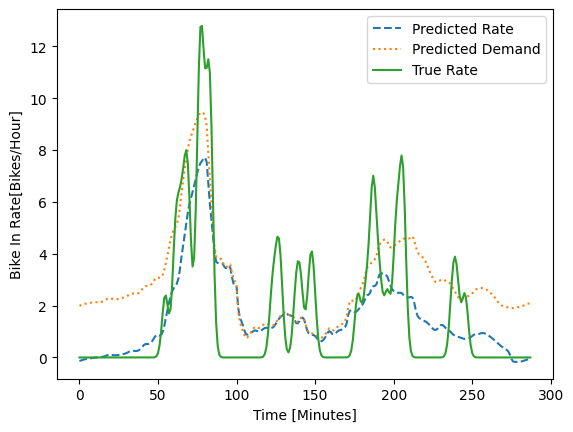

In [27]:
import plotting
importlib.reload(plotting)
# extract the main model demand prediction versus predicted rates and true rates
model, cfg, short_name = models[0], cfgs[0], cfg_names[0]

evals_list, d, y_rate_preds, y_demand_preds, y_truths = evaluated_results[0]

y_rate_preds = y_rate_preds.cpu().numpy()
y_demand_preds = y_demand_preds.cpu().numpy()
y_truths = y_truths.cpu().numpy()

_plot = plotting.plot_station_over_time_reg(y_rate_preds, y_demand_preds, y_truths, i_station = 4, horizon = 4, cfg = cfg, title = f"")


In [26]:
importlib.reload(typst)
# compare root rate error in [bikes / hour], demand violation rate on the test set and output as typst table
# and compare difference between predicted rate and demand
model_short_names = ["STGAT", "STGAT-upscaled", "STGAT-transformer"]
table = []

for cfg, model, short_name, eval_result in zip(cfgs, models, model_short_names, evaluated_results):
    evals_list, d, y_rate_preds, y_demand_preds, y_truths = eval_result
    metrics = [d['RRateMSE'].item(), d['RDemMSViol'].item(), d['RSmoothViol'].item()]
    table.append([short_name] + [f'${met:.3}$' for met in metrics])

    

print(table)
typst.print_typst_table(table, col_names=["Model", "RRateMSE", "RDemMSViol", "RSmoothViol"])

[['STGAT', '$1.59$', '$1.26$', '$0.00313$']]
#table(columns: 4,
table.header([Model], [RRateMSE], [RDemMSViol], [RSmoothViol]),
[STGAT], [$1.59$], [$1.26$], [$0.00313$])


[Text(0.5, 1.0, 'Station 4 for Horizon 20'),
 Text(0.5, 0, 'Time [Minutes]'),
 Text(0, 0.5, 'Bike In Rate[Bikes/Hour]')]

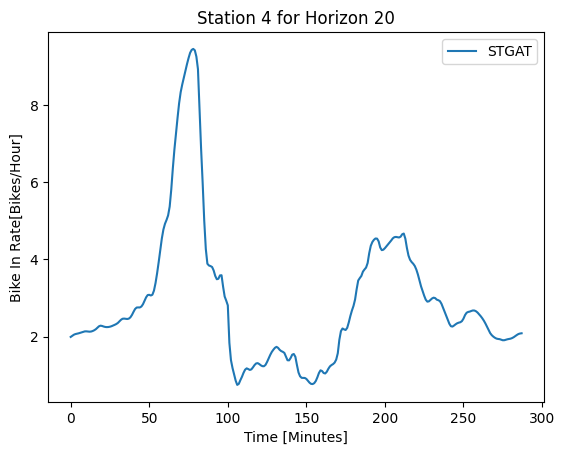

In [31]:
# compare demand predictions of different models

horizon = 4 # 20 mins
horizon_minutes = horizon * cfg.subsample_minutes
i_station = 4
in_rate = True
ylabel = 'In Rate'
args = {'title':f'Station {i_station} for Horizon {horizon_minutes}', 'xlabel':'Time [Minutes]', 'ylabel': 'Bike ' + ylabel + '[Bikes/Hour]'}
plt.clf()
times = np.arange(0, 288)
for cfg, short_name, eval_result in zip(cfgs, model_short_names, evaluated_results):
    evals_list, d, y_rate_preds, y_demand_preds, y_truths = eval_result
    plotting.plot_horizon_over_time(y_demand_preds.cpu().numpy(), i_station, horizon = horizon, times = times, in_rate = in_rate, cfg = cfg, label = short_name)

plt.legend()
plt.gca().set(**args)

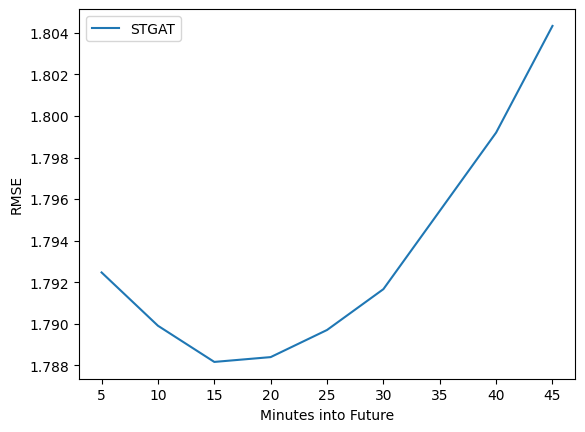

In [33]:
# horizon comparison
# plot accuracies for different horizons
for cfg, short_name, eval_result in zip(cfgs, model_short_names, evaluated_results):
    evals_list, d, y_rate_preds, y_demand_preds, y_truths = eval_result
    
    rmses_per_step = np.sqrt(d['MSE per step'].cpu().numpy())
    
    subsample_mins = cfg['subsample_minutes']
    minutes = np.arange(1 * subsample_mins, (len(rmses_per_step) + 1) * subsample_mins, subsample_mins)
    
    plt.plot(minutes, rmses_per_step, label = short_name)


args = {'title':'', 'xlabel':'Minutes into Future', 'ylabel':'RMSE'}
plt.gca().set(**args)
plt.legend()



In [ ]:
# horizon over the learning process for cfg0: standard stgat
cfg0
model_checkpoints = [cfg.save_interval * i for i in range(1, cfg.max_iterations // cfg.save_interval + 1)]

